# Introduction

In this notebook we demonstrate the use of LSI (Latent Semantic Indexing) Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Load Dataset and Preprocessing

In [2]:
trace_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
artfs_desc_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

# LSI Model

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, pairwise_distances
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

class LSI:
    def __init__(self):
        self.name = "LSI"
        
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                             use_idf=True, 
                                             smooth_idf=True)
        
        self.svd_model = TruncatedSVD(n_components = 100, 
                                         algorithm = 'randomized',
                                         n_iter = 10, 
                                         random_state = 42)
        self.trace_links_df = None          
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        svd_transformer = Pipeline([('tfidf', self.vectorizer), 
                            ('svd', self.svd_model)])

        svd_matrix = svd_transformer.fit_transform(corpus)
        query_vector = svd_transformer.transform(query)
        
        distance_matrix = pairwise_distances(query_vector, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)
        
        trace_results_df = pd.DataFrame(use_cases_names)
        bug_reports_list = bug_reports_names

        for i in range(0, len(list(distance_matrix))):
            trace_results_df[bug_reports_list[i]] = distance_matrix[i]
        
        self.trace_links_df = trace_results_df.copy()
        self.trace_links_df.set_index('artf_name', inplace=True)

        amount_target_docs = use_cases_df.shape[0]
        cols = trace_results_df.columns.delete(0)  # delete artf_name
        
        threshold = 3
        for col in cols:
            """ return top threshold documents"""
            nlargest_df = trace_results_df.nlargest(n = threshold, columns=col, keep='first')    
            self.trace_links_df[col] = [1 if x in nlargest_df[col].tolist() else 0 for x in self.trace_links_df[col]]


class OracleLoader:
    def __init__(self, rows_names, columns_names):
        self.oracle = None
        self._columns_names = columns_names
        self._rows_names = rows_names
    
    def load(self):
        self.oracle = pd.DataFrame(columns=list(self._columns_names))
        self.oracle.insert(0, 'artf_name', list(self._rows_names))
        
        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

        
class ModelEvaluator:
    def __init__(self, scores, oracle, model):
        self.model_name = model.name
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
    
    def evaluate_model(self):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in self.oracle.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1

    def print_report(self):
        mean_precision = self.eval_df.precision.mean()
        mean_recall = self.eval_df.recall.mean()
        mean_fscore = self.eval_df.fscore.mean()
        
        print("Mean Precision of {}: {:2.3}".format(self.model_name, mean_precision))
        print("Mean Recall of {}: {:2.3}".format(self.model_name, mean_recall))
        print("Mean F-Score of {}: {:2.3}".format(self.model_name, mean_fscore))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(10,10))
        plt.plot(self.eval_df.precision, self.eval_df.recall, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.legend()
        plt.show()

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

Mean Precision of LSI: 0.0214
Mean Recall of LSI: 0.143
Mean F-Score of LSI: 0.0368


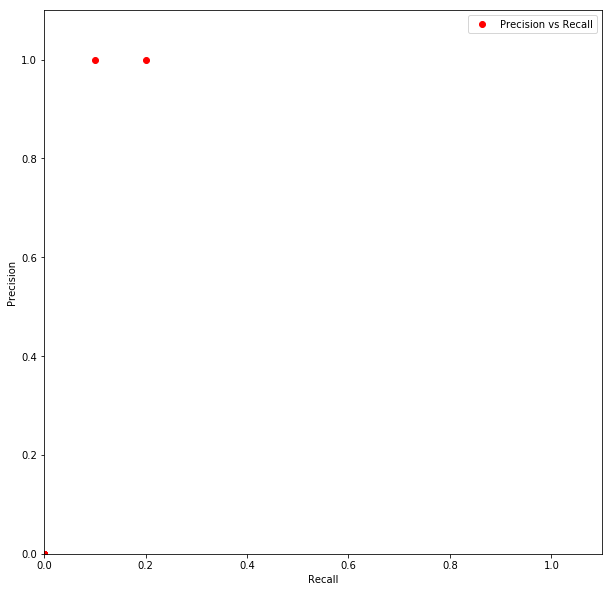

In [4]:
corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

lsi_model = LSI()
lsi_model.recover_links(corpus, query, use_cases_names, bug_reports_names)

orc = OracleLoader(use_cases_names, bug_reports_names)
orc.load()

evaluator = ModelEvaluator([], orc.oracle, lsi_model)
evaluator.evaluate_model()
evaluator.print_report()
evaluator.plot_precision_vs_recall()